# OHM Bond Volatility Research

## Summary

The research created here aims to discern the drivers of system volatility as it relates to bond release. Different parameterizations of bond release and the overall system are studied to determine the main effects.

## Experimental Set Up/Parameters

For each of the experiments below, there is a separate experimental set up described.

## KPIs

The following KPIs are measured in the experiments:

- Price Volatility / Price Change Standard Deviation: The standard deviation of the percentage price changes in the simulation, a common measure of volatility.

## Success Metrics:

- Medium Volatility: The success metric here is true when the price volatility is < .30, indicating a reasonable level of volatility.


# Experiment 1 - Release Date Distribution Effect

## Experimental Setup

- The simulations are generally run with the normal parameters
- The bond scheduling is the change applied in this experiment
- There are three sets of bond release schedules and two levels of total face value which are compared against one and other

## Parameter Sweep

- total_face_value: The total amount of face value attributed to the bond release
    - Values are 2e6 and 5e6
- bond_value_distribution: The distribution between the values for each bond distribution. The larger the number, the higher the share of the total face value that is released at that given date.
    - Values are [1, 1, 1], [2, 1, 1], [4, 1, 1]

TODO：
- add reference of price volatility: no bond
- add sem for the bond
- clear the kpi process to be simpler

In [5]:
from model.utility.default_parameters import default_params1 as params
from model.signals.bond_signals import total_value_bond_creation
from model.utility.default_initial_state import default_initial_state1 as initial_state
from model.utility.initial_state_functions import fill_in_initial_state
from model.run import load_config, run,new_run, post_processing
import pandas as pd

# Create the different bonds
bonds = []
bond_schedule_name = []

# start with an empty bond -- no ohm bonds
bonds.append(pd.DataFrame([], columns=['start_days', 'bonds']))
bond_schedule_name = ['No Bond']

# Universal Bond Params
start_dates = [10,30,50]
bond_tenors = 30

# Run parameters
number_runs = 10
number_steps = 100

# Equal value release bond
for distribution in [[1,1,1],[2,1,1],[4,1,1]]:
    for name,total_face_value in {'Med':2e6,'Lrg':5e6}.items():
        bonds.append(total_value_bond_creation(start_dates= start_dates,
                                  simulation_timesteps=number_steps,
                                  bond_tenors=bond_tenors,
                                  total_face_value=total_face_value,
                                  bond_value_distribution=distribution))
        bond_schedule_name.append("{0}/{1}/{2} ".format(*distribution)+name)

params.update({'bond_create_schedule':bonds})
params.update({'bond_schedule_name':bond_schedule_name})

# Fill in the initial state
initial_state = fill_in_initial_state(initial_state, params)

# Load the experiment
exp = load_config(number_runs, params, initial_state, number_steps)

# Run the experiment
raw = new_run(exp)

# Parse the raw data
# df1 = post_processing(raw) # without no-bond condition as a reference
# df1.to_csv("bond_research_runs1.csv")

df1a = post_processing(raw)
df1a.to_csv("bond_research_runs1a.csv")



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 24, 70, 69)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 24, 70, 69)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 308.49s


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#df1 = pd.read_csv("bond_research_runs1.csv", index_col=0)
df1 = pd.read_csv("bond_research_runs1a.csv", index_col=0)
number_steps = 100

### KPIs and Success Metrics

In [5]:
df1["bond_schedule_name"] = df1["bond_schedule_name"].fillna(method='bfill')

# Get the amount that front loading was favored
df1["front_load_amount"] = df1["bond_schedule_name"].apply(lambda x: x[0]).map({"1":1,"2":2,'4':4,'N':0})

# Get face value in e6 terms
df1["face_value"] = df1["bond_schedule_name"].apply(lambda x: x.split(" ")[-1]).map({"Med": 2,
                                                                "Lrg": 5, "Bond":0})
std = df1.groupby("unique_id").apply(lambda x: x['price'].pct_change().std())
std.name = "price_volatility"


from model.utility.panic_sell_metrics import fun_pooldrained
pooldrained = fun_pooldrained(df1)
pooldrained=pd.Series(pooldrained,index = df1.unique_id.unique())
pooldrained.name = 'pool_drained_probability'

descriptors = df1.groupby("unique_id")[['front_load_amount',
 'face_value',]].last()
kpis = pd.concat([std,pooldrained, descriptors], axis=1)

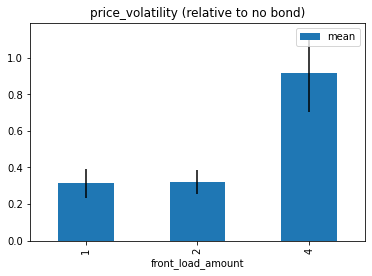

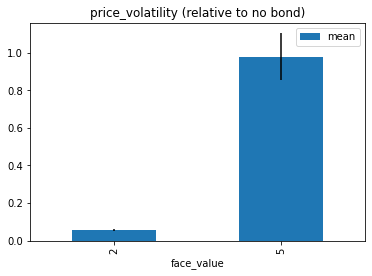

In [7]:
from model.utility.ohmbond_metrics import plot_relative_kpi
kpi = 'price_volatility'
plot_relative_kpi(kpi,kpis,descriptors)

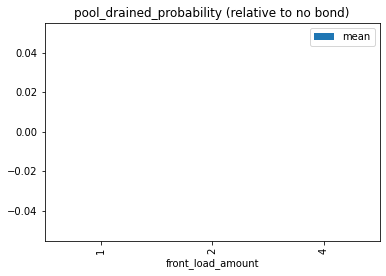

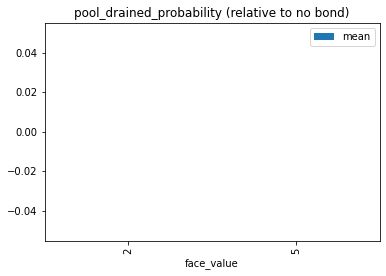

In [9]:
kpi = 'pool_drained_probability'
plot_relative_kpi(kpi,kpis,descriptors)

No pool drainage happened, so for this experiment we will ignore this kpi.

## Quantitative feature analysis
We use the decision tree as well as random forest regression to understand the importance of features

In [28]:
def tree_regression_analysis(df,xnames:list,yname:str):
    from sklearn.tree import DecisionTreeRegressor,plot_tree
    # fit the tree
    X = kpis[xnames]
    y = kpis[yname]
    tree = DecisionTreeRegressor(max_depth=2)
    tree.fit(X, y)
    # plot the tree
    fig,ax = plt.subplots(figsize = (15,6))
    plot_tree(tree,
              rounded=True,
              proportion=True,
              fontsize=8,
              feature_names=X.columns,
              class_names=['High Volatility', 'Reasonable Volatility'],
              filled=True,ax=ax)
    
    ax.set_title(f'Decision tree, score: {tree.score(X, y) :.0%}. N: {len(X) :.2e}')
              


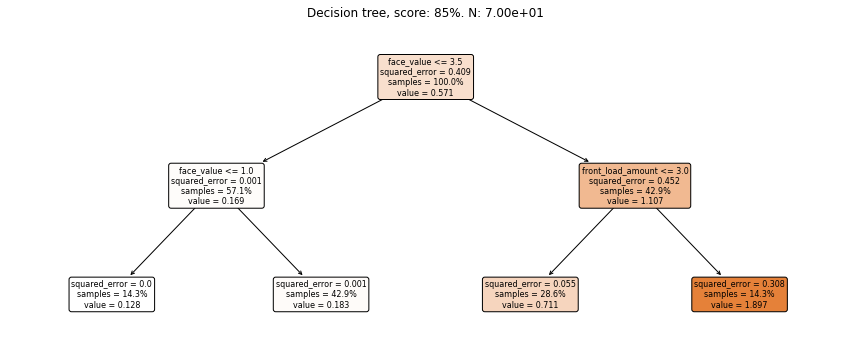

In [29]:
kpi = 'price_volatility'
tree_regression_analysis(df1,['front_load_amount','face_value',],kpi)

In [30]:
def randomforest_regression_analysis(df,xnames:list,yname:str):
    from sklearn.ensemble import RandomForestRegressor
    # fit model
    X = kpis[xnames]
    y = kpis[yname]
    rf = RandomForestRegressor()
    rf.fit(X, y)
    importance = (pd.DataFrame(list(zip(X.columns, rf.feature_importances_)),
                        columns=['features', 'importance'])
            .sort_values(by='importance', ascending=False)
            )
    
    # plot the feature importance
    import seaborn as sns
    fig,ax = plt.subplots(figsize = (15,6))

    sns.barplot(data=importance,
                    x=importance.features,
                    y=importance.importance,
                    ax=ax,
                    label='small')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    ax.set_title(f'Feature Importance')
    



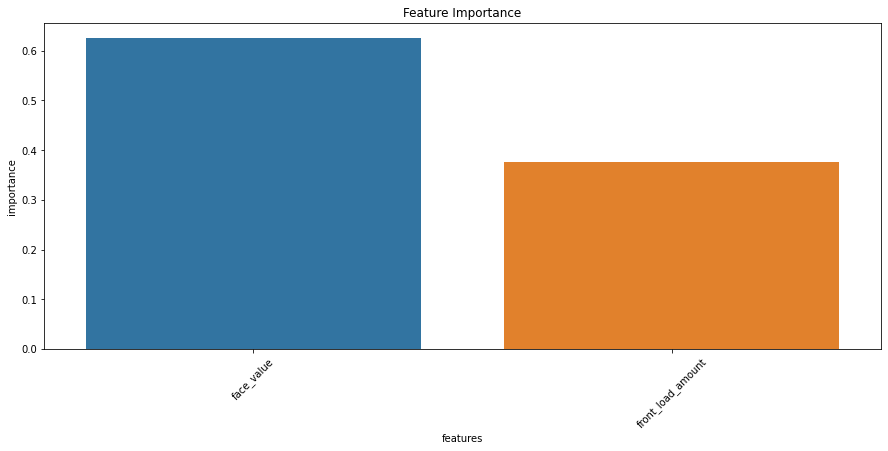

In [31]:
kpi = 'price_volatility'
randomforest_regression_analysis(df1,['front_load_amount','face_value',],kpi)

### Decision Tree Analysis (classification)

The following analysis finds the drivers of success for the system.

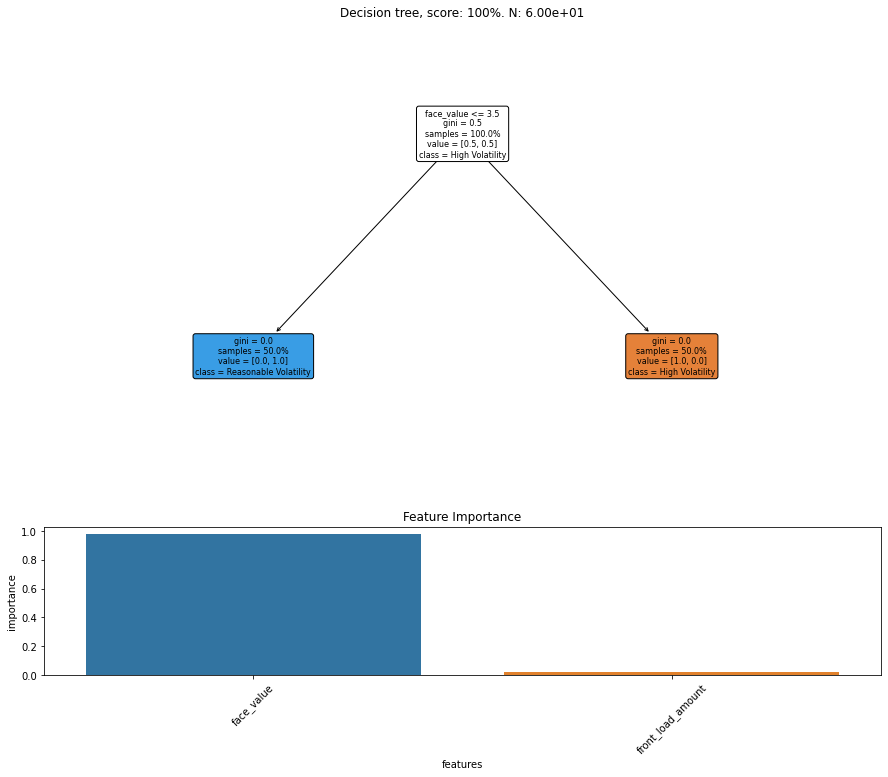

In [39]:
factors = ['front_load_amount',"face_value"]
y = "medium_volatility"

from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

X = success_metrics[factors].copy()
y = success_metrics[y].copy()

fig, axes = plt.subplots(nrows=2,
                             figsize=(15, 12),
                             gridspec_kw={'height_ratios': [3, 1]})

model = DecisionTreeClassifier(max_depth=3)
rf = RandomForestClassifier()
model.fit(X, y)
rf.fit(X, y)

importance = (pd.DataFrame(list(zip(X.columns, rf.feature_importances_)),
                       columns=['features', 'importance'])
          .sort_values(by='importance', ascending=False)
          )

plot_tree(model,
              rounded=True,
              proportion=True,
              fontsize=8,
              feature_names=X.columns,
              class_names=['High Volatility', 'Reasonable Volatility'],
              filled=True,
              ax=axes[0])

axes[0].set_title(
        f'Decision tree, score: {model.score(X, y) :.0%}. N: {len(X) :.2e}')
sns.barplot(data=importance,
                x=importance.features,
                y=importance.importance,
                ax=axes[1],
                label='small')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)
axes[1].set_title(f'Feature Importance')

plt.show()

To conclude: in the current settings, having bond will increase the price volatility compared to no bonds. The volatility is mainly contributed by the face value, less about the front_load_amount.

However this conclusion is constrained by the fact we didn't use overly large total_amount for bonds. In the next experiment, we will explore a larger range of bond total amount as well as changing the tenor of bonds (i.e. same starting dates, different release dates).

# Experiment 2: different distribution of bond amount regarding different tenors

In [12]:
from model.utility.default_parameters import default_params1 as params
from model.signals.bond_signals import total_value_bond_creation
from model.utility.default_initial_state import default_initial_state1 as initial_state
from model.utility.initial_state_functions import fill_in_initial_state
from model.run import load_config, run,new_run, post_processing
import pandas as pd

# Create the different bonds
bonds = []
bond_schedule_name = []

# start with an empty bond -- no ohm bonds
bonds.append(pd.DataFrame([], columns=['start_days', 'bonds']))
bond_schedule_name = ['No Bond']

# Universal Bond Params
start_dates = [10]
bond_tenors = [30,60,90]

# Run parameters
number_runs = 16
number_steps = 100

# Equal value release bond
for distribution in [[1,1,1],[2,1,1],[4,1,1]]:
    for name,total_face_value in {'Med':2e6,'Lrg':5e6,'XLrg':8e6}.items():
        bonds.append(total_value_bond_creation(start_dates= start_dates,
                                  simulation_timesteps=number_steps,
                                  bond_tenors=bond_tenors,
                                  total_face_value=total_face_value,
                                  bond_value_distribution=distribution))
        bond_schedule_name.append("{0}/{1}/{2} ".format(*distribution)+name)

params.update({'bond_create_schedule':bonds})
params.update({'bond_schedule_name':bond_schedule_name})

# Fill in the initial state
initial_state = fill_in_initial_state(initial_state, params)

# Load the experiment
exp = load_config(number_runs, params, initial_state, number_steps)

# Run the experiment
raw = new_run(exp)

# Parse the raw data
# df1 = post_processing(raw) # without no-bond condition as a reference
# df1.to_csv("bond_research_runs1.csv")

df2 = post_processing(raw)
df2.to_csv("bond_research_runs2.csv")



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 24, 160, 69)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 24, 160, 69)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 619.38s


## Analysis on experiment 2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df2 = pd.read_csv("bond_research_runs2.csv", index_col=0)
number_steps = 100

### Get features and kpis

In [13]:
df2["bond_schedule_name"] = df2["bond_schedule_name"].fillna(method='bfill')

# Get the amount that front loading was favored
df2["front_load_amount"] = df2["bond_schedule_name"].apply(lambda x: x[0]).map({"1":1,"2":2,'4':4,'N':0})

# Get face value in e6 terms
df2["face_value(e6)"] = df2["bond_schedule_name"].apply(lambda x: x.split(" ")[-1]).map({"Med": 2,
                                                                "Lrg": 5, 'XLrg':8,"Bond":0})

df2["max_single_bond_value(e6)"] =(df2["face_value(e6)"]*df2["front_load_amount"]/(2+ df2["front_load_amount"])).round(1)


std = df2.groupby("unique_id").apply(lambda x: x['price'].pct_change().std())
std.name = "price_volatility"


from model.utility.panic_sell_metrics import fun_pooldrained
pooldrained = fun_pooldrained(df2)
pooldrained=pd.Series(pooldrained,index = df2.unique_id.unique())
pooldrained.name = 'pool_drained_probability'

descriptors = df2.groupby("unique_id")[['front_load_amount',
 'face_value(e6)','max_single_bond_value(e6)']].last()
kpis = pd.concat([std,pooldrained, descriptors], axis=1)

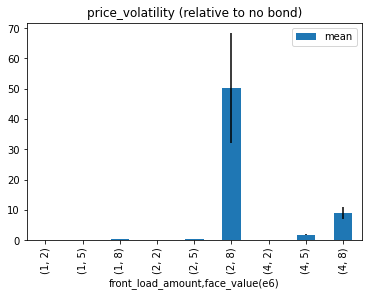

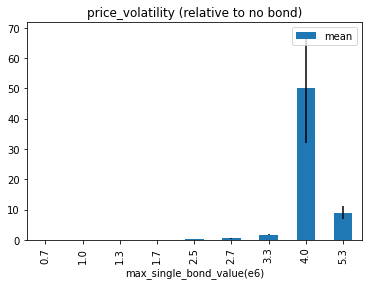

In [14]:
from model.utility.ohmbond_metrics import plot_relative_kpi
kpi = 'price_volatility'
plot_relative_kpi(kpi,kpis,descriptors,group_vars=[['front_load_amount','face_value(e6)'],'max_single_bond_value(e6)'])

Here's a surprising observation: with a relatively large total face value (8e6), the medium level of front load (2:1:1) actually have the chance to cause more price volatility than more extreme level of front load, which will more likely directly drain the whole pool thus the overall price volatility is not as large. This is shown below

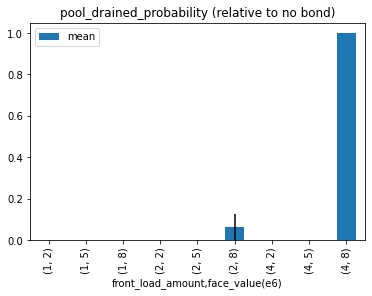

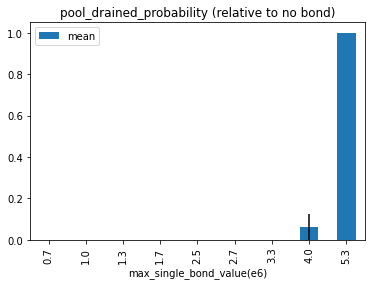

In [28]:
kpi = 'pool_drained_probability'
plot_relative_kpi(kpi,kpis,descriptors,group_vars=[['front_load_amount','face_value(e6)'],'max_single_bond_value(e6)'])

## Quantitative feature analysis

In [39]:
from model.utility.visualization import tree_regression_analysis,randomforest_regression_analysis

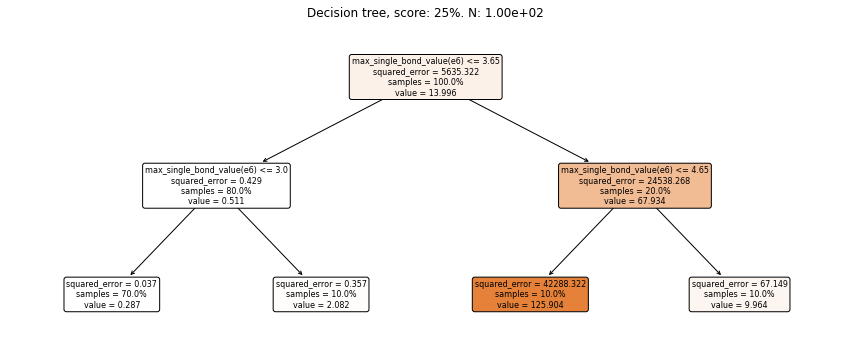

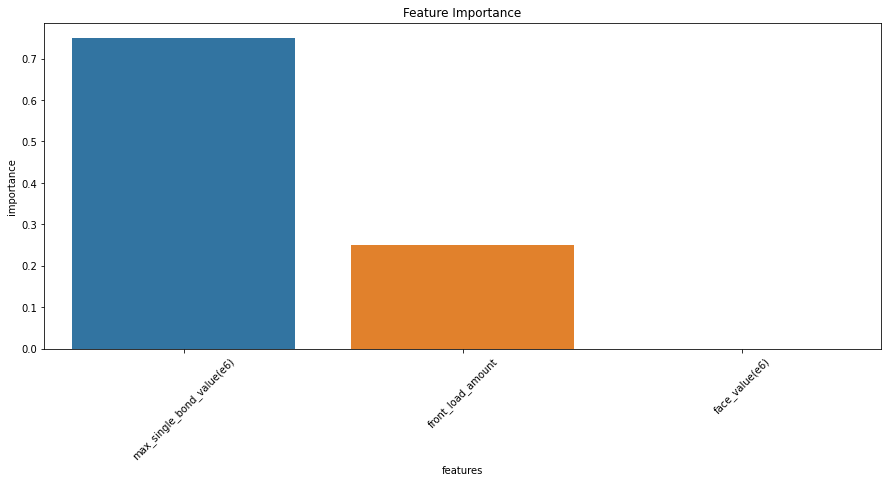

In [14]:
kpi = 'price_volatility'
tree_regression_analysis(kpis,descriptors.columns,kpi,tree_depth = 2)
randomforest_regression_analysis(kpis,descriptors.columns,kpi)

For volatility, the model fitting score is not very well (25% in decision tree model), thus the feature importance analysis is not very reliable either. This is because of how now with higher face value compared to experiment 1, the high face_value, high front_load situation will actually drain the pool rather than pushing up the price volatility, therefore not showing up an easier monotomic relation between the features and the kpi.

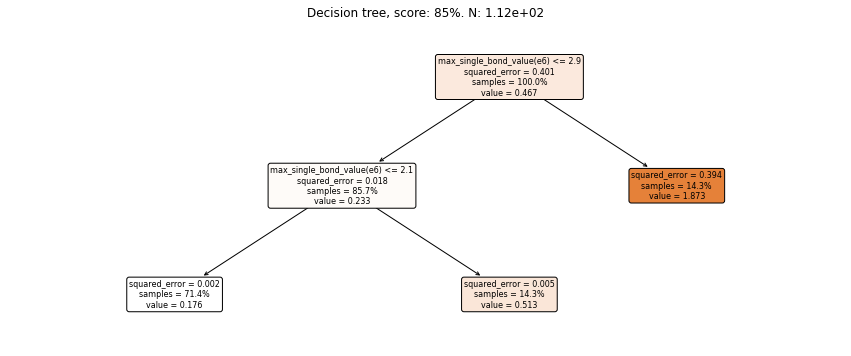

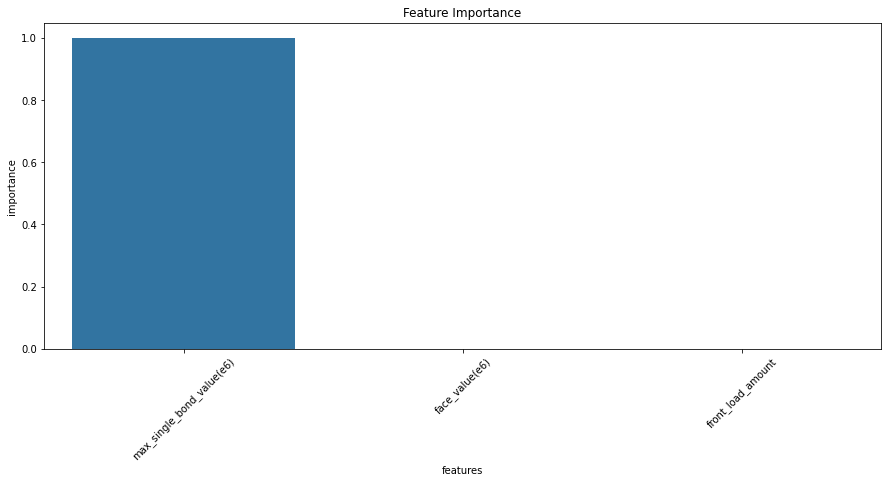

In [40]:
kpi = 'price_volatility'
subkpi_df = kpis.loc[kpis['face_value(e6)']<8]
tree_regression_analysis(subkpi_df,descriptors.columns,kpi,tree_depth = 2)
randomforest_regression_analysis(subkpi_df,descriptors.columns,kpi)

Excluding the extremely large face value, we see the max_single_bond_value is the most important feature that is positively correlated with price volatility

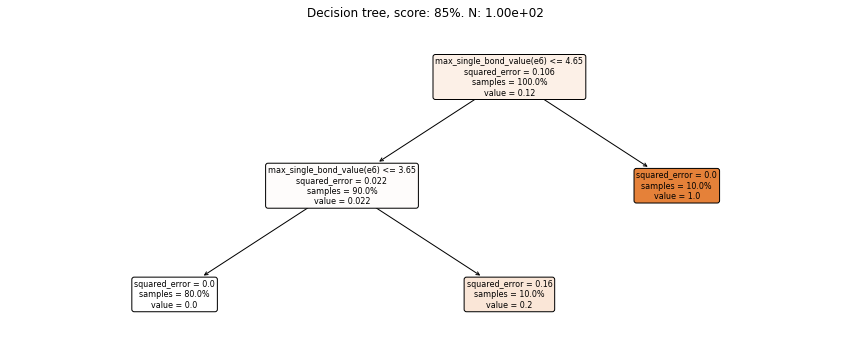

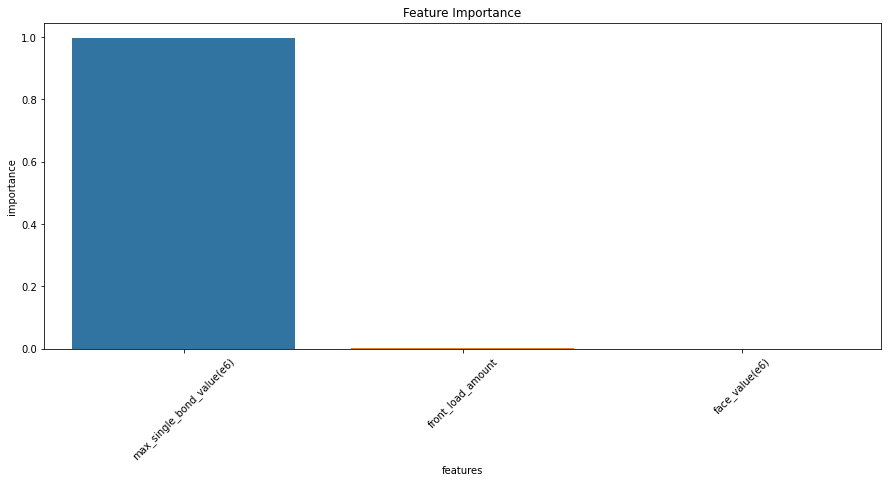

In [15]:
kpi = 'pool_drained_probability'

tree_regression_analysis(kpis,descriptors.columns,kpi,tree_depth=2)
randomforest_regression_analysis(kpis,descriptors.columns,kpi)

The max value of a single bond is clearly the most significant factor regarding how likely the issuance of ohm bond will drain the pool.

### how does pool drainage happen?

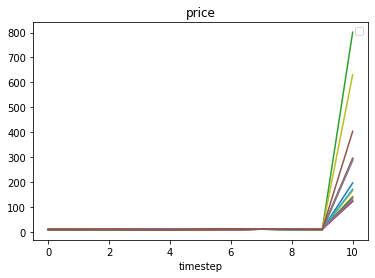

In [35]:
from model.utility.visualization import plot_all_sims
# plot all simulations of Extra large total face value and 4-1-1 front load
plot_all_sims(['price'],df2.loc[(df2["face_value(e6)"]==8)*(df2["front_load_amount"]==4)])

All the drainage happens when the bond is issued and we assume people pool a significant amount of OHM out of the liquidity pool to buy bonds, causing the pool to drain. This is indicating that the bond is too big for the pool depth, especially given now all 3 bonds are issued at the same day. 

# Conclusion from Experiment 1 & 2
In Experiment 1 we explored different starting dates of different bonds and varying the face value of the bonds. We found that face value contributes more to the price volatility than the ratio of each bond's value distribution. Bond overall will cause more price volatility than without bonds.

In Experiment 2 we explored different tenors of bonds with same starting dates and varying the face value, this time also adding more extreme ranges of high bond face values. We found that for really high face value (8e6 in this case) it's much more likely to drain the pool. In a more reasonable face value range, we also introduced the alternative feature of "max_single_bond_value" which well predicts the price volatility.

For future studies, other factors can be looked into:
- the impact factor from bond to netflow
- overall market activity volatility (the randomization of netflow)

# Experiment 3: volatility with or without RBS

In [28]:
from model.utility.default_parameters import default_params1 as params
from model.signals.bond_signals import total_value_bond_creation
number_runs = 10
number_steps = 100
val_ratio1=[2,1,1]

total_amount = 3e6
bond0 = total_value_bond_creation(start_dates= 5, simulation_timesteps=number_steps, bond_tenors=[30,60,90], total_face_value=total_amount,bond_value_distribution=[])
bond1 = total_value_bond_creation(start_dates= 5, simulation_timesteps=number_steps, bond_tenors=[30,60,90], total_face_value=total_amount,bond_value_distribution=val_ratio1)
val_ratio2 = [3,1,1]
bond2 = total_value_bond_creation(start_dates= 5, simulation_timesteps=number_steps, bond_tenors=[30,60,90], total_face_value=total_amount,bond_value_distribution=val_ratio2)

params.update({'bond_create_schedule':[bond0,bond1,bond2]})
params.update({'bond_schedule_name':['equal value','value ratio for diff tenors:'+str(val_ratio1),'value ratio for diff tenors:'+str(val_ratio2)]})
from model.utility.default_initial_state import default_initial_state1 as initial_state
# Fill in the initial state
from model.utility.initial_state_functions import fill_in_initial_state
initial_state = fill_in_initial_state(initial_state, params)

from model.run import load_config, run, post_processing
# Load the experiment
exp = load_config(number_runs, params, initial_state, number_steps,psub_scenario_option='NoRBS')

# Run the experiment
raw = run(exp)

# Parse the raw data
df3 = post_processing(raw)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 22, 30, 69)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 22, 30, 69)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 82.19s


subset
0    0.0
1    0.0
2    0.0
Name: timestep, dtype: float64


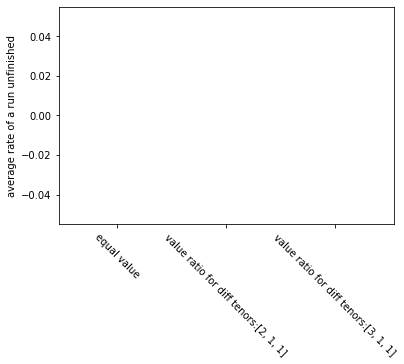

In [29]:
from model.utility.visualization import plot_simu_interruption_rate
plot_simu_interruption_rate(df3,number_steps)

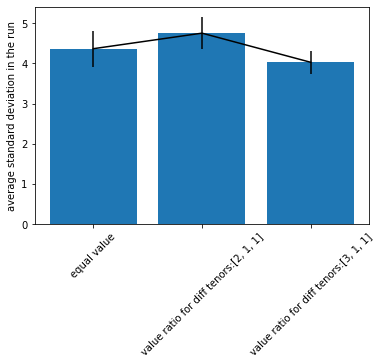

In [29]:
from model.utility.visualization import plot_price_standard_deviation

plot_price_standard_deviation(df3)          


In [3]:
# import pickle
# [df1,df2,df3] = pickle.load(open('simudata/ohmbond_research/simu_df.p','rb'))

/home/zhiwei/Documents/blockscience/OlympusRBS/model/utility/visualization.py:66: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


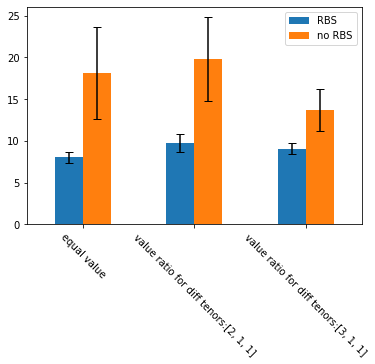

In [4]:
from model.utility.visualization import plot_price_standard_deviation_multiple_exps
exps = [{'label':'RBS','df':df2},{'label':'no RBS','df':df3}]
plot_price_standard_deviation_multiple_exps(exps)

with RBS, the volatility increases significantly. The bond distribution still doesn't have a significant effect on volatility though.

In [32]:
# import pickle
# pickle.dump([df1,df2,df3],open('simudata/ohmbond_research/simu_df.p','wb'))

# Experiment 4: bond amount and possibility of draining the pool

In [24]:
from model.utility.default_parameters import default_params1 as params
from model.signals.bond_signals import total_value_bond_creation
number_runs = 10
number_steps = 100

total_amounts = [4e6,4.5e6,5e6]
allbonds = []
for amount in total_amounts:
    allbonds.append(total_value_bond_creation(start_dates= 5, simulation_timesteps=number_steps, bond_tenors=[30,60,90], total_face_value=amount,bond_value_distribution=[]))

params.update({'bond_create_schedule':allbonds})
params.update({'bond_schedule_name':[f'total amount {k:.1e}' for k in total_amounts]})
from model.utility.default_initial_state import default_initial_state1 as initial_state
# Fill in the initial state
from model.utility.initial_state_functions import fill_in_initial_state
initial_state = fill_in_initial_state(initial_state, params)

from model.run import load_config, run,new_run, post_processing
# Load the experiment
exp = load_config(number_runs, params, initial_state, number_steps)

# Run the experiment
raw = new_run(exp)

# Parse the raw data
df4 = post_processing(raw)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 22, 30, 69)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 22, 30, 69)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 78.32s


subset
0    0.0
1    0.5
2    1.0
Name: timestep, dtype: float64


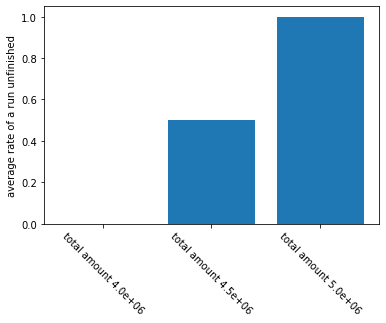

In [5]:
from model.utility.visualization import plot_simu_interruption_rate
plot_simu_interruption_rate(df4,number_steps=100)

In [26]:
import pickle
pickle.dump(df4,open('simudata/ohmbond_research/simu_df4.p','wb'))

# Experiment 5: does RBS help to prevent pool drainage?

In [5]:
from model.utility.default_parameters import default_params1 as params
from model.signals.bond_signals import total_value_bond_creation
number_runs = 10
number_steps = 100

total_amounts = [4e6,4.5e6,5e6]
allbonds = []
for amount in total_amounts:
    allbonds.append(total_value_bond_creation(start_dates= 5, simulation_timesteps=number_steps, bond_tenors=[30,60,90], total_face_value=amount,bond_value_distribution=[]))

params.update({'bond_create_schedule':allbonds})
params.update({'bond_schedule_name':[f'total amount {k:.1e}' for k in total_amounts]})
from model.utility.default_initial_state import default_initial_state1 as initial_state
# Fill in the initial state
from model.utility.initial_state_functions import fill_in_initial_state
initial_state = fill_in_initial_state(initial_state, params)

from model.run import load_config, run,new_run, post_processing
# Load the experiment
exp = load_config(number_runs, params, initial_state, number_steps,psub_scenario_option='NoRBS')

# Run the experiment
raw = new_run(exp)

# Parse the raw data
df5 = post_processing(raw)
pickle.dump(df5,open('simudata/ohmbond_research/simu_df5.p','wb'))


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 22, 30, 69)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 22, 30, 69)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 37.96s


In [1]:
import pickle
df5 = pickle.load(open('simudata/ohmbond_research/simu_df5.p','rb'))
df4 = pickle.load(open('simudata/ohmbond_research/simu_df4.p','rb'))

/home/zhiwei/Documents/blockscience/OlympusRBS/model/utility/visualization.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


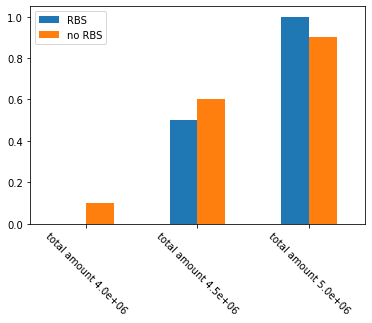

In [2]:
from model.utility.visualization import plot_simu_interruption_rate_multiple_exps
exps = [{'label':'RBS','df':df4},{'label':'no RBS','df':df5}]
plot_simu_interruption_rate_multiple_exps(exps,number_steps=100)

RBS doesn't necessarily reduce the chance of pool being drained.